# Fast Upsampling in a Single Forward Pass with FeatUp (JBU)

> ⚠️ Change your collab runtime to T4 GPU before running this notebook

In this notebook we will walk through how to load and work with our catalog of pre-trained upsamplers that work with common vision backbones such as CLIP, DINO, DINO v2, and ResNet50. We note that we add a Layer Norm operation to each of these backbones prior to upsampling so keep this in mind if you are trying to replace an existing component with one of our upsampled variants. This is controlled by the `use_norm=True` flag.

In [1]:
!git clone https://github.com/mhamilton723/FeatUp

Cloning into 'FeatUp'...
remote: Enumerating objects: 357, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 357 (delta 127), reused 115 (delta 115), pack-reused 194 (from 1)
Receiving objects: 100% (357/357), 39.05 MiB | 13.78 MiB/s, done.
Resolving deltas: 100% (193/193), done.


## Install FeatUp and our fast Joint Bilateral Upsampling (JBU) Kernel

> ⚠️ This cell will take 3-5 minutes to run because of cuda kernel compilation


In [2]:
import os
os.chdir("FeatUp/")

In [3]:
!pip install -e .
!pip install git+https://github.com/mhamilton723/CLIP.git

Obtaining file:///content/FeatUp
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.22
    Uninstalling timm-1.0.22:
      Successfully uninstalled timm-1.0.22
  Running setup.py develop for featup
  Cloning https://github.com/mhamilton723/CLIP.git to /tmp/pip-req-build-pltsbvq4
  Running command git clone --filter=blob:none --quiet https://github.com/mhamilton723/CLIP.git /tmp/pip-req-build-pltsbvq4
  Resolved https://github.com/mhamilton723/CLIP.git to commit dce9d43cc659cb9a013745b378c78077fde6aac0
  Preparing metadata (setup.py) ..

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

In [43]:
input_size = 224
image_path = "sample-images/wing_casse.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True

transform = T.Compose([
    T.Resize(input_size),
    T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    norm
])

image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

## DINO

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
INFO:lightning_fabric.utilities.seed:Seed set to 0


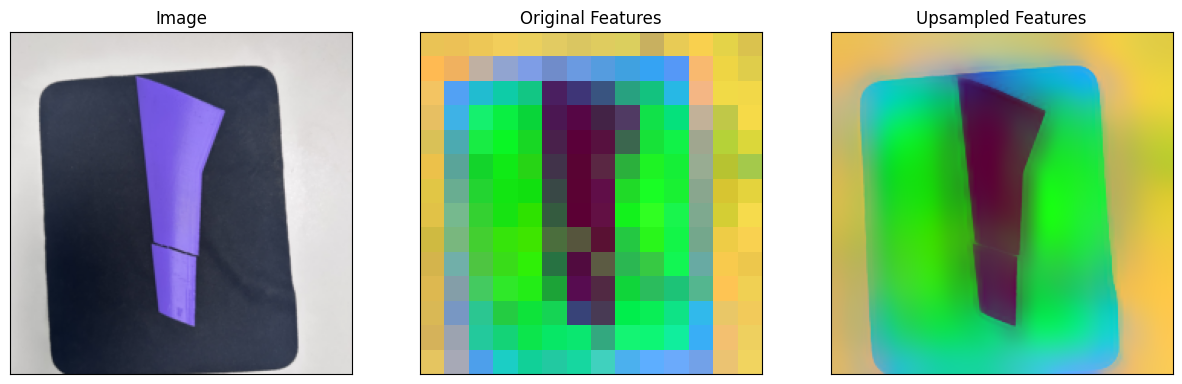

In [44]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dino16', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

## DINO v2

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
INFO:lightning_fabric.utilities.seed:Seed set to 0


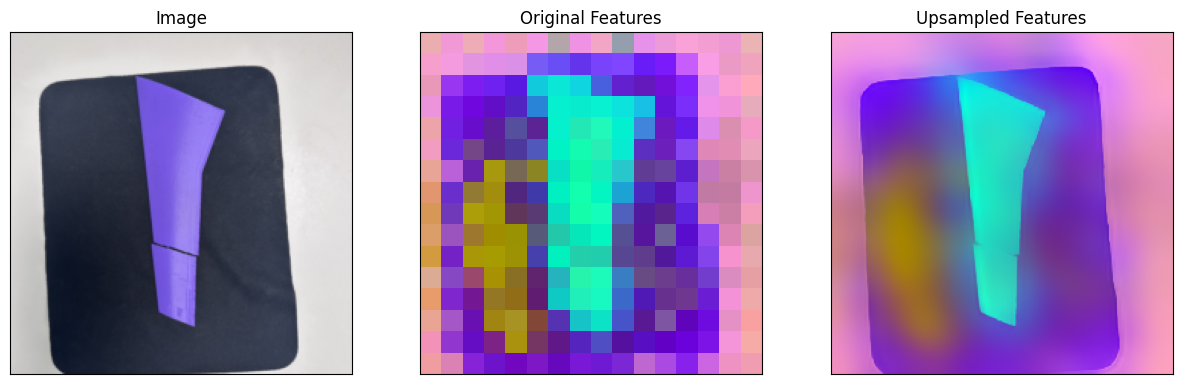

In [45]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

## CLIP

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
INFO:lightning_fabric.utilities.seed:Seed set to 0


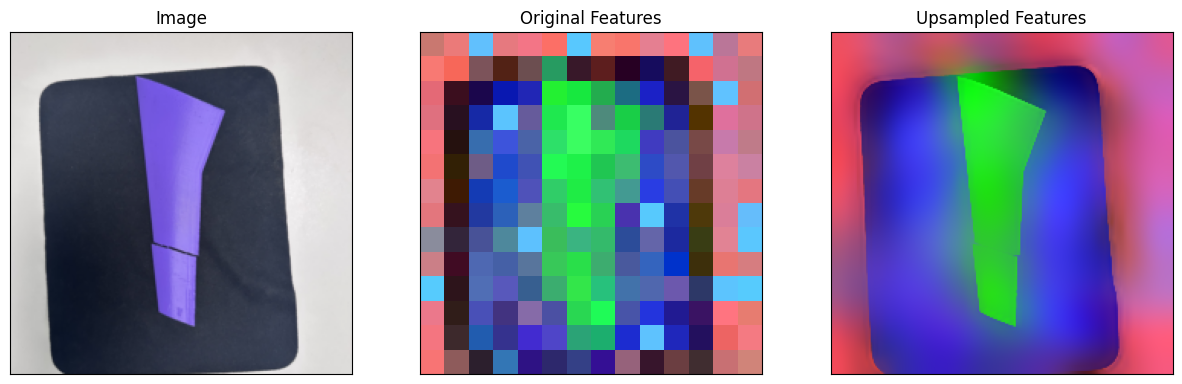

In [46]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'clip', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# MaskCLIP
## Note: Use this version of CLIP for text alignment

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
INFO:lightning_fabric.utilities.seed:Seed set to 0


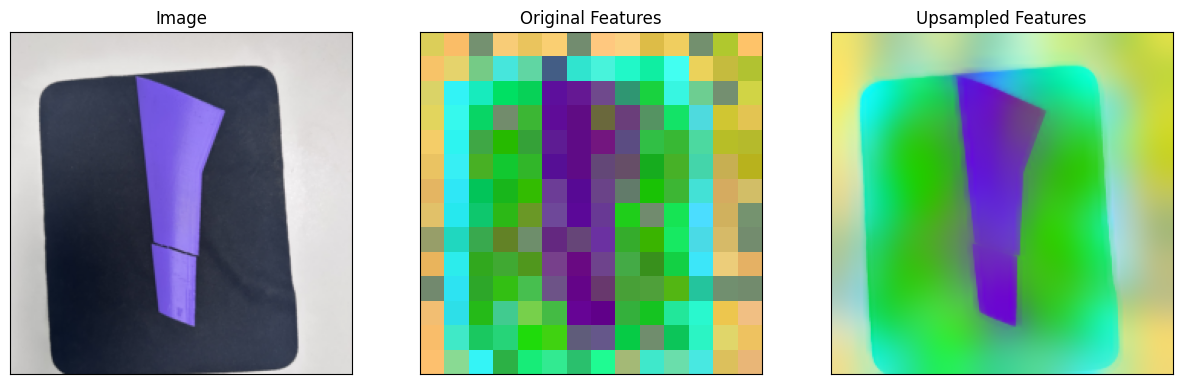

In [47]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'maskclip', use_norm=False).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

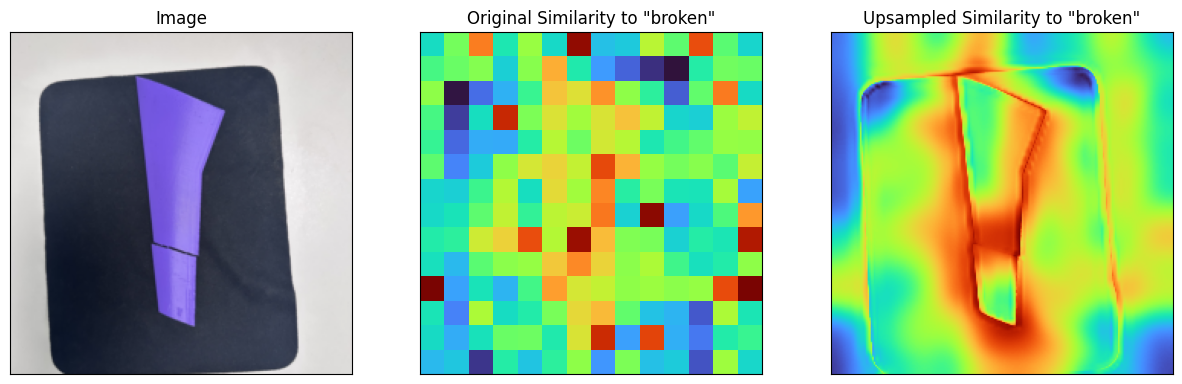

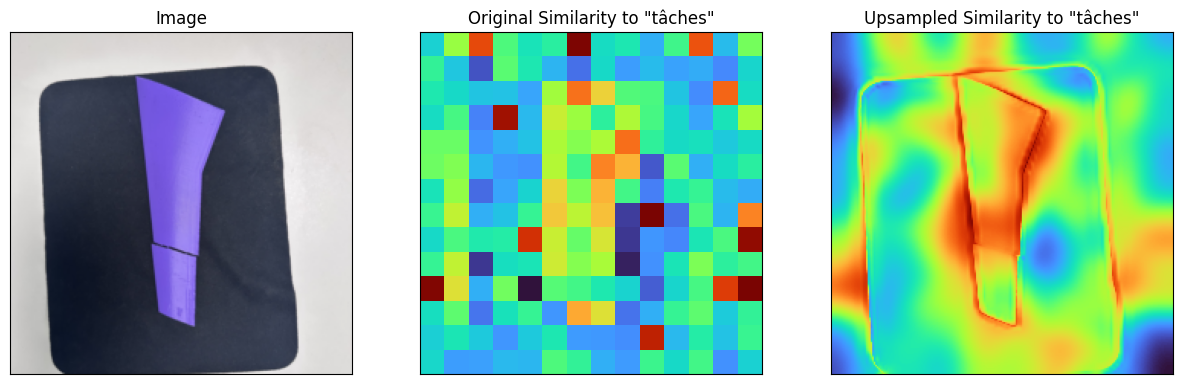

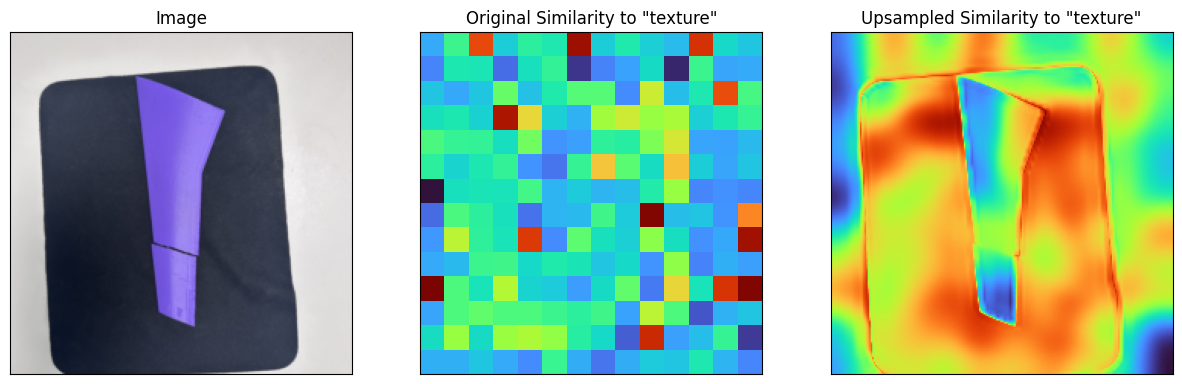

In [48]:
text_queries = ["broken", "tâches", "texture"]

for text_query in text_queries:
    plot_lang_heatmaps(upsampler.model, unnorm(image_tensor)[0], lr_feats[0], hr_feats[0], text_query)

# ViT

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/vit_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/vit_jbu_stack_cocostuff.ckpt
100%|██████████| 2.04M/2.04M [00:00<00:00, 5.84MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


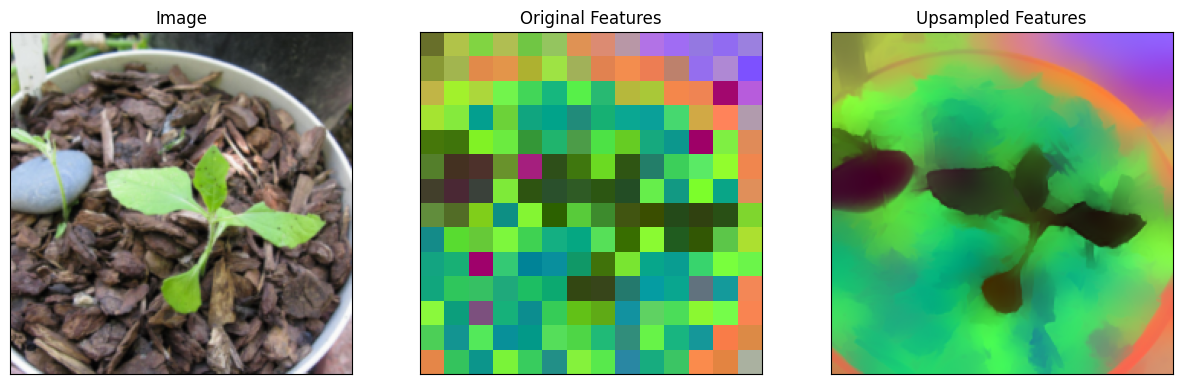

In [ ]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'vit', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

# ResNet 50

Using cache found in /root/.cache/torch/hub/mhamilton723_FeatUp_main
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]
Downloading: "https://marhamilresearch4.blob.core.windows.net/feature-upsampling-public/pretrained/resnet50_jbu_stack_cocostuff.ckpt" to /root/.cache/torch/hub/checkpoints/resnet50_jbu_stack_cocostuff.ckpt
100%|██████████| 48.4M/48.4M [00:01<00:00, 31.4MB/s]
INFO:lightning_fabric.utilities.seed:Seed set to 0


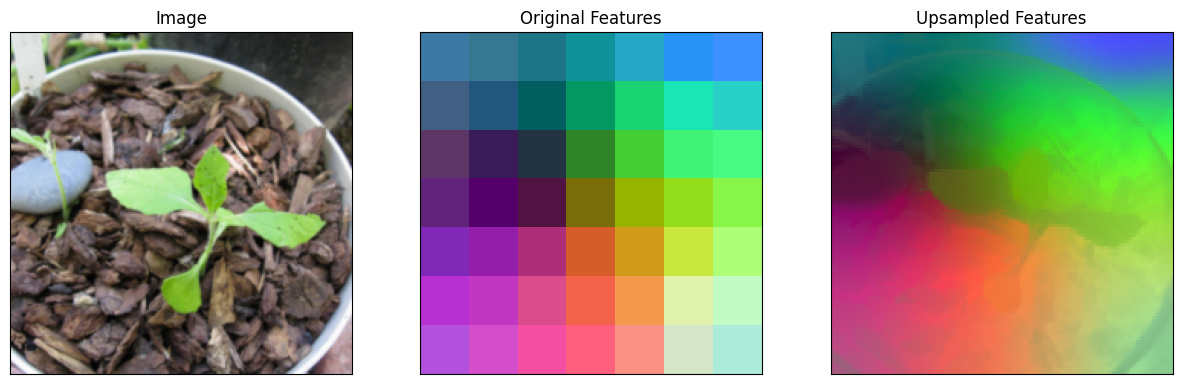

In [ ]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'resnet50', use_norm=use_norm).to(device)
hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

INFO:lightning_fabric.utilities.seed:Seed set to 0


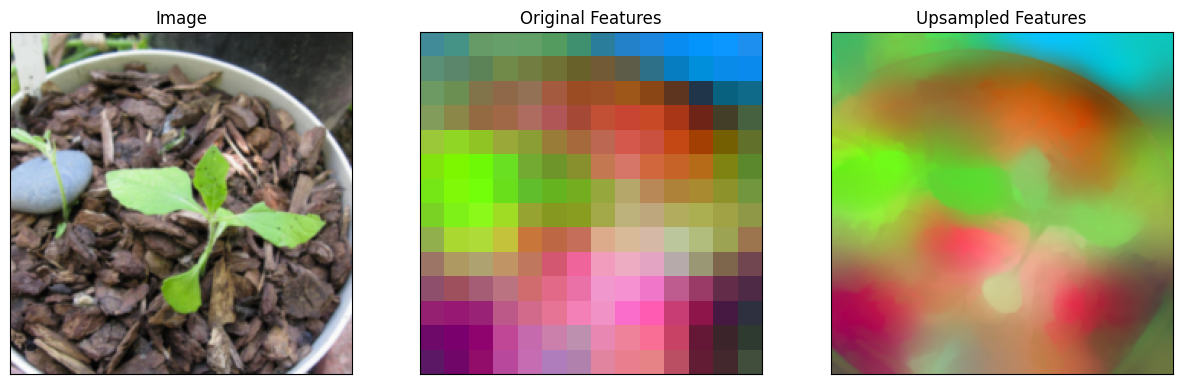

In [ ]:
import torch.nn.functional as F

big_img = F.interpolate(image_tensor, scale_factor=2, mode='bilinear')
hr_feats = upsampler(big_img)
lr_feats = upsampler.model(big_img)
plot_feats(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])